In [42]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

In [5]:
plt.style.use('dark_background')

In [9]:
N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

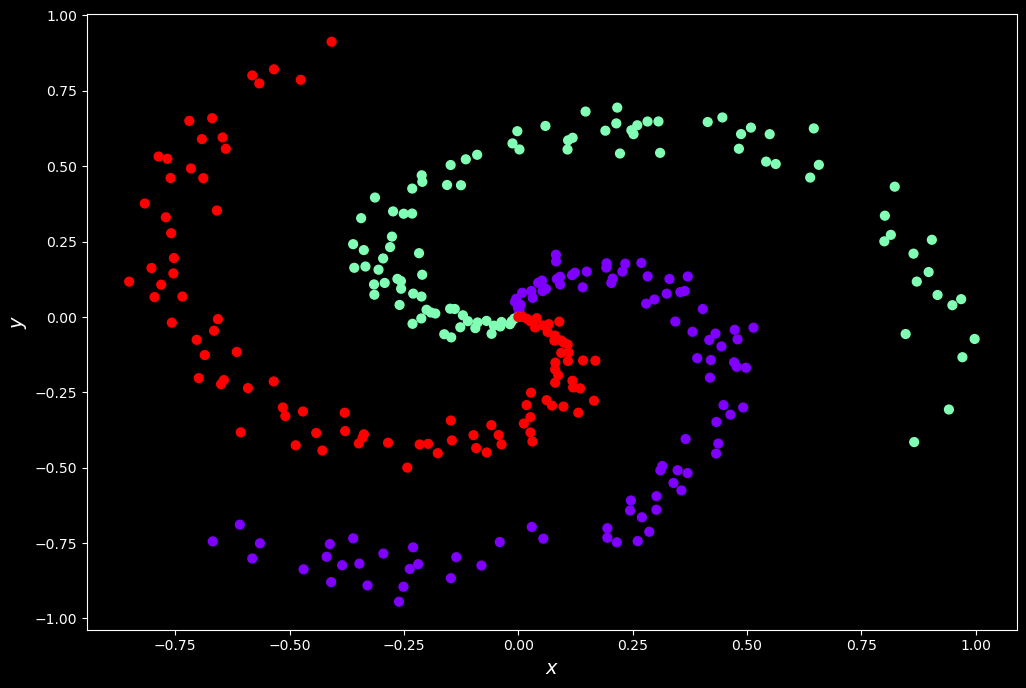

In [14]:
plt.figure(figsize=(12, 8))

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

In [36]:
X = torch.FloatTensor(X)
y = torch.LongTensor(y)

In [37]:
# D_in - размерность входа
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя
D_in, H, D_out = 2, 100, 3

two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Softmax()
)

$$Softmax(x) = \begin{pmatrix} 
\dfrac{e^{x_1}}{\sum\limits_{i=0}^{m} e^{x_i}},\; \dots,\; \dfrac{e^{x_m}}{\sum\limits_{i=0}^{m} e^{x_i}}
\end{pmatrix} $$

$$CrossEntropy(x) = -\sum\limits_{i=0}^m y_i \cdot log(Softmax(x)_i), $$

где $y_i$ – истинная метка класса ($1$ если $x$ принадлежит $i$-ому классу и $0$ иначе)

In [38]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.f_lin = nn.Linear(D_in, H)
        self.s_lin = nn.Linear(H, D_out)
        
    def forward(self, X):
        X = F.relu(self.f_lin(X))
        return F.softmax(self.s_lin(X), dim=1)

In [39]:
model = MyModule()
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), 1e-1)

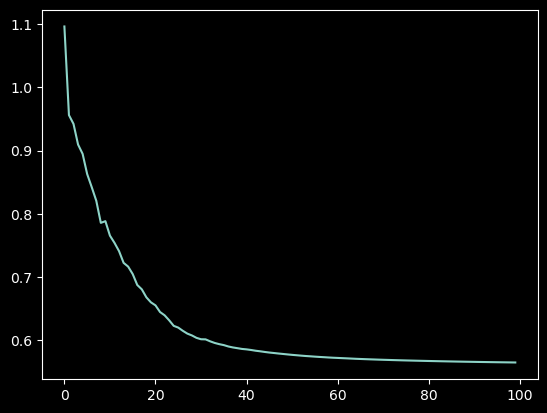

In [40]:
losses = []
for t in range(100):
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    losses.append(loss.item())

    optim.zero_grad()
    loss.backward()
    optim.step()
    
plt.plot(losses)

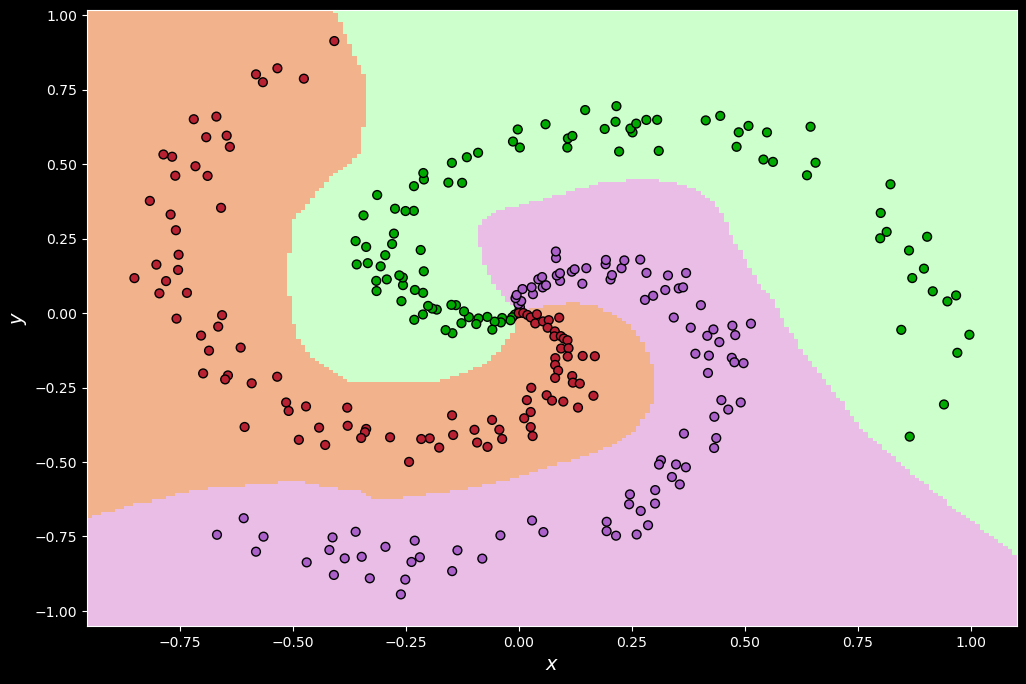

In [63]:
eps = 0.1
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Предсказание модели
with torch.no_grad():
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.argmax(dim=1).numpy() 

Z = Z.reshape(xx.shape)

# Цветовая схема (3 класса)
cmap_light = ListedColormap(['#EABDE6', '#CCFFCC', '#F2B28C'])
cmap_bold = ['#AA60C8', '#00AA00', '#B82132']               

plt.figure(figsize=(12, 8))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(cmap_bold), s=40, edgecolor='k')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show()